In [1]:
import matplotlib.pyplot as plt
from tqdm import trange

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
import numpy as np

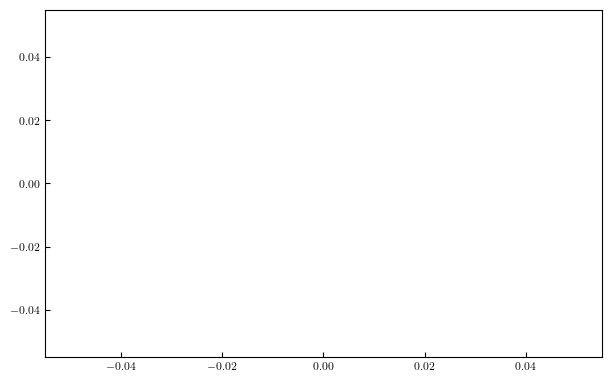

In [40]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 10,
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1,
    'figure.figsize': (6, 6/1.618),
    'figure.constrained_layout.use': True,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})

In [4]:
import numpy as np
import pyccl as ccl 

# cosmology
h=0.6736
omch2 = 0.1200
ombh2 = 0.02237
Omc = omch2/h**2
Omb = ombh2/h**2
ns = 0.9649
sigma8 =  0.8111

cosmo = ccl.Cosmology(Omega_c=Omc, Omega_b=Omb,
                          h=h, n_s=ns, sigma8=sigma8)

zstar = 1100
cmbk = ccl.CMBLensingTracer(cosmo, z_source=zstar)

# sampling range
zmax_sample = zstar
amax_sample = 1/(zmax_sample+1)
chimax_sample = ccl.comoving_radial_distance(cosmo, amax_sample)

chis = np.linspace(0, chimax_sample, 10**4)
Wk = cmbk.get_kernel(chis)[0]

a_s = ccl.scale_factor_of_chi(cosmo, chis)
zs = 1/a_s - 1

Dz = ccl.growth_factor(cosmo, a_s)


L = chimax_sample
dchi = jnp.mean(jnp.diff(chis))
ks = 2*jnp.pi*jnp.fft.fftfreq(len(chis), d=dchi)
sort_idx = jnp.argsort(ks)

# power spectrum
P1Dk = ccl.linear_matter_power(cosmo, np.abs(ks), 1)
P1Dk[0] = 0.0 #fix mean
P1Dk = jnp.array(P1Dk)

# set up log space k bins
n_k_bins = 25
k_bin_edges = np.hstack([[0], np.logspace(np.log10(2*jnp.pi/L), np.log10(jnp.pi/dchi), n_k_bins)])
k_bin_edges = jnp.array(k_bin_edges)
k_bin_centers = jnp.sqrt(k_bin_edges[1:]*k_bin_edges[:-1])
bin_indices = jnp.digitize(ks, k_bin_edges) - 1

def count_for_bin(bin_idx):
        return jnp.sum(jnp.where(bin_indices == bin_idx, 1, 0))
bin_counts = jax.vmap(count_for_bin)(jnp.arange(n_k_bins))

# get rid of empty bins

empty_bins = (bin_counts == 0)
non_empty_bins = ~empty_bins
new_k_bin_edges = [k_bin_edges[0]]

new_bin_idx = 0

for i in range(n_k_bins):
    if(non_empty_bins[i]):
        new_k_bin_edges.append(k_bin_edges[i+1])
        new_bin_idx += 1
        
k_bin_edges = jnp.array(new_k_bin_edges)
k_bin_centers = jnp.sqrt(k_bin_edges[1:]*k_bin_edges[:-1])

bin_indices = jnp.digitize(ks, k_bin_edges) - 1
n_k_bins = len(k_bin_edges) - 1
bin_counts = jax.vmap(count_for_bin)(jnp.arange(n_k_bins))

# kernels in fourier space
Kkappa_x = jnp.array(Wk*Dz)
Kkappa_k = jnp.fft.fft(Kkappa_x) * dchi #dchi to put numpy convention to my convention

_KI = (chis-chis[-1])**2 #just a parabola that resembles our LIMs kernel
KI_k = jnp.fft.fft(_KI) * dchi
_KIbar = jnp.mean(_KI) #factor chosen so that large scale <I kappa> roughly same

# which filtering to look at
Lambdas = [0.0, 1e-1]

/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/pyccl/pk2d.py:285: RuntimeWarning: divide by zero encountered in log
  lk_use = np.log(k_use)


# Theory spectra

In [5]:
# theory spectra
expected_Ik_kappa = 1/L * jnp.sum((jnp.interp(x = ks.reshape(-1, 1) 
                                              - ks.reshape(1, -1),
                                              xp = ks[sort_idx],
                                              fp = KI_k[sort_idx],
                                              left = 0, right = 0) 
                                   * (Kkappa_k*P1Dk).reshape(1, -1)), 
                                  axis = -1)

expected_kappa2 = jnp.real(1/L * jnp.sum(Kkappa_k * jnp.conj(Kkappa_k) * P1Dk))

@jax.jit
def bin_Ik(i):
    mask =  (bin_indices == i)
    return jnp.sum(jnp.where(mask, expected_Ik_kappa, 0.0)) / jnp.sum(mask)

binned_Ik_kappa = jax.vmap(bin_Ik)(jnp.arange(n_k_bins))


# no LC
expected_Ik_kappa_noLC = _KIbar*Kkappa_k*P1Dk

@jax.jit
def bin_Ik_noLC(i):
    mask =  (bin_indices == i)
    return jnp.sum(jnp.where(mask, expected_Ik_kappa_noLC, 0.0)) / jnp.sum(mask)

binned_Ik_kappa_noLC = jax.vmap(bin_Ik_noLC)(jnp.arange(n_k_bins))

In [6]:
# <I I*>
_ks = ks[sort_idx]
_KI_k = KI_k[sort_idx]

interp_q = jnp.interp(
        x= ks.reshape(-1,1) - ks.reshape(1, -1),
        xp=_ks,
        fp=_KI_k,
        left=0, right=0)
@jax.jit
def compute_element(k):
    interp_k = jnp.interp(
        x=k - ks.reshape(1, -1),
        xp=_ks,
        fp=jnp.conj(_KI_k),
        left=0, right=0)
    result = jnp.sum(interp_k * interp_q * P1Dk.reshape(1, -1), axis=-1)
    return result / L
    
expected_II = np.zeros((len(ks), len(ks)), dtype = np.complex128)

for _i in trange(len(ks)):
    _k = ks[_i]
    expected_II[_i] = compute_element(_k)

# <I I*> no LC
expected_II_noLC = L * jnp.diag(_KIbar**2 * P1Dk)

100%|██████████| 10000/10000 [00:41<00:00, 241.20it/s]


In [7]:
cov = expected_kappa2 * expected_II + expected_Ik_kappa.reshape(-1, 1) * jnp.conj(expected_Ik_kappa).reshape(1, -1)
cov_noLC = (expected_kappa2 * expected_II_noLC 
            + expected_Ik_kappa_noLC.reshape(-1, 1) 
            * jnp.conj(expected_Ik_kappa_noLC).reshape(1, -1))


@jax.jit
def bin_cov(idx0, idx1):
    mask_x = (idx0 == bin_indices)
    mask_y = (idx1 == bin_indices)
    mask = mask_x.reshape(-1, 1) * mask_y.reshape(1, -1)
    return jnp.sum(jnp.where(mask, cov, 0.0)) / jnp.maximum(1, jnp.sum(mask))
    
binned_cov = jax.vmap(jax.vmap(bin_cov, in_axes=(None, 0)), in_axes=(0,None))(jnp.arange(n_k_bins), jnp.arange(n_k_bins))


@jax.jit
def bin_cov_noLC(idx0, idx1):
    mask_x = (idx0 == bin_indices)
    mask_y = (idx1 == bin_indices)
    mask = mask_x.reshape(-1, 1) * mask_y.reshape(1, -1)
    return jnp.sum(jnp.where(mask, cov_noLC, 0.0)) / jnp.maximum(1, jnp.sum(mask))
    
binned_cov_noLC = jax.vmap(jax.vmap(bin_cov_noLC, in_axes=(None, 0)), in_axes=(0,None))(jnp.arange(n_k_bins), jnp.arange(n_k_bins))

In [8]:
# projected
Lambdas = np.hstack(([0],np.array(k_bin_edges[:-1])))

def process_projected(Lambda):
    mask = (jnp.abs(ks) >= Lambda)
    _expected_Ik_projected = 1/L * jnp.sum(jnp.where(mask, 
                                                     (jnp.conj(Kkappa_k) * KI_k * P1Dk), 
                                                     0))
    _expected_II_projected = 1/L * jnp.sum(jnp.where(mask, 
                                                     (jnp.conj(KI_k) * KI_k * P1Dk), 
                                                     0))

    return jnp.array([_expected_Ik_projected, _expected_II_projected])
expected_projected = jnp.zeros((len(Lambdas),2))
expected_projected = jax.vmap(process_projected)(Lambdas)

SNR2s_proj = np.zeros(len(Lambdas))
for LIDX in trange(len(Lambdas)):
    _expected_var_proj = (expected_projected[LIDX,0]*jnp.conj(expected_projected[LIDX,0]) 
                          + expected_kappa2 * expected_projected[LIDX,1])
    SNR2s_proj[LIDX] = jnp.real(expected_projected[LIDX,0]*jnp.conj(expected_projected[LIDX,0]) / _expected_var_proj)

100%|██████████| 24/24 [00:00<00:00, 92.60it/s]


# computing SNR

In [9]:
n_runs = 720000
oup_mc_fname = '/sdf/scratch/users/d/delon/toy_model_LIMxCMBL/monte_carlo_toy_model_nrun_%d.pkl'%(n_runs)
import pickle
with open(oup_mc_fname, 'rb') as f:
    measured_spectra = pickle.load(f)

In [10]:
_binned_cov = np.array(binned_cov)
SNR2s = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov[kill_idx:, kill_idx:], jnp.conj(binned_Ik_kappa[kill_idx:]))
    SNR2s[kill_idx] = jnp.real(binned_Ik_kappa[kill_idx:] @ x)


_binned_cov_noLC = np.array(binned_cov_noLC)
SNR2s_noLC = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov_noLC[kill_idx:, kill_idx:], jnp.conj(binned_Ik_kappa_noLC[kill_idx:]))
    SNR2s_noLC[kill_idx] = jnp.real(binned_Ik_kappa_noLC[kill_idx:] @ x)

100%|██████████| 23/23 [00:00<00:00, 666.48it/s]


In [11]:
_binned_cov = np.array(measured_spectra['LC_binned_cov'])
estimated_SNR2s = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov[kill_idx:, kill_idx:], 
                                      jnp.conj(measured_spectra['LC_binnedIk'][kill_idx:]))
    estimated_SNR2s[kill_idx] = jnp.real(measured_spectra['LC_binnedIk'][kill_idx:] @ x)


_binned_cov = np.array(measured_spectra['nLC_binned_cov'])
estimated_SNR2s_noLC = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov[kill_idx:, kill_idx:], 
                                      jnp.conj(measured_spectra['nLC_binnedIk'][kill_idx:]))
    estimated_SNR2s_noLC[kill_idx] = jnp.real(measured_spectra['nLC_binnedIk'][kill_idx:] @ x)


_binned_cov = np.array(binned_cov)
estimated_SNR2s_hybrid = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov[kill_idx:, kill_idx:], 
                                      jnp.conj(measured_spectra['LC_binnedIk'][kill_idx:]))
    estimated_SNR2s_hybrid[kill_idx] = jnp.real(measured_spectra['LC_binnedIk'][kill_idx:] @ x)


_binned_cov = np.array(binned_cov_noLC)
estimated_SNR2s_hybrid_noLC = np.zeros(n_k_bins)

for kill_idx in trange(n_k_bins):
    x,resid,rank,s = jnp.linalg.lstsq(_binned_cov[kill_idx:, kill_idx:], 
                                      jnp.conj(measured_spectra['nLC_binnedIk'][kill_idx:]))
    estimated_SNR2s_hybrid_noLC[kill_idx] = jnp.real(measured_spectra['nLC_binnedIk'][kill_idx:] @ x)

100%|██████████| 23/23 [00:00<00:00, 768.29it/s]


In [12]:
#estimates of projection
estimated_Ik_proj = measured_spectra['proj'][:,0]/n_runs
print('Ik proj rel err', jnp.real((estimated_Ik_proj - expected_projected[:, 0])/expected_projected[:,0]))

estimated_II_proj = measured_spectra['proj'][:,1]/n_runs
print('II proj rel err', jnp.real(estimated_II_proj - expected_projected[:, 1])/expected_projected[:, 1])

estimated_var_proj = estimated_II_proj*expected_kappa2 + estimated_Ik_proj*jnp.conj(estimated_Ik_proj)

Ik proj rel err [ 2.39513189e-03  2.39513189e-03 -4.76375660e-03 -1.27568713e-02
  1.24081737e-01  1.55905974e-01  4.93420563e-01  5.16844073e-01
  1.53005848e+00  4.16690346e+00  6.80150400e-02 -1.22546975e+00
 -6.83898771e+00 -1.90922958e+01 -4.19099473e+01  5.99867661e+01
  3.20207554e+02  1.72412687e+03 -1.86823891e+03  6.20862095e+03
  2.04887864e+04 -1.42209524e+04  4.51092880e+04  1.14894952e+04]
II proj rel err [-0.00356922+0.j -0.00356922+0.j -0.00165082+0.j -0.000461  +0.j
 -0.00038852+0.j  0.00098514+0.j  0.00164332+0.j  0.00325262+0.j
  0.00200808+0.j  0.00227992+0.j  0.00126634+0.j -0.00069122+0.j
  0.00218135+0.j  0.0003967 +0.j -0.00015093+0.j  0.00524485+0.j
 -0.00055441+0.j  0.00141147+0.j  0.00094754+0.j -0.00027175+0.j
 -0.00145064+0.j  0.00150403+0.j  0.00178998+0.j  0.00141939+0.j]


/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


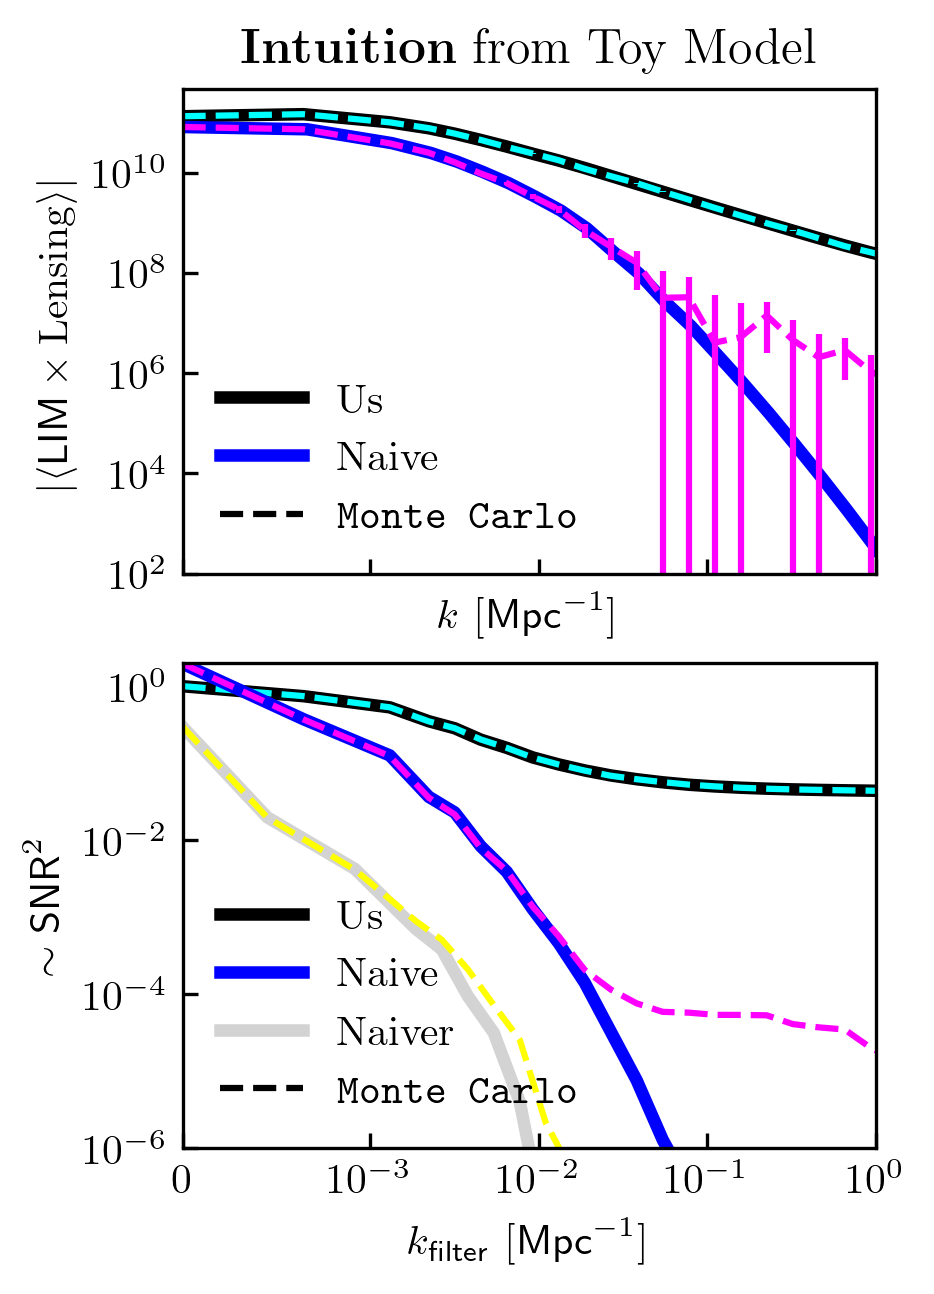

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3,4.2), dpi=300)

axs[0].set_title(r'\textbf{Intuition} from Toy Model')

# <Ik> plot

axs[0].plot(k_bin_centers, jnp.abs(binned_Ik_kappa), 
         label='Us', c='k', lw=3)
axs[0].plot(k_bin_centers*jnp.exp(0.03), jnp.abs(binned_Ik_kappa_noLC), 
         label='Naive', c='b', lw=3)


color = {'LC': 'cyan', 'nLC':'magenta'}
for _type in ['LC', 'nLC']:
    curr_spectra = jnp.abs(measured_spectra[_type+'_binnedIk'])


    #I think this is a good estimate of the errorbar
    curr_mse = jnp.real(measured_spectra[_type+'_Ik_MSE'])/n_runs/(n_runs-1)
    def bin_MSE(bin_idx):
        mask = bin_indices == bin_idx
        #add in quadrature
        return jnp.sum(jnp.where(mask, curr_mse, 0.0))/jnp.sum(mask)/(jnp.sum(mask)-1)

    binned_rmse = jnp.sqrt(jax.vmap(bin_MSE)(jnp.arange(n_k_bins)))

    offset = 1
    # if(_type == 'nLC'):
    #     offset = jnp.exp(0.03) 

    axs[0].errorbar(k_bin_centers*offset, curr_spectra, yerr=jnp.real(binned_rmse), ls='--', c=color[_type])



axs[0].plot([0, 100], [-100, -100], c='k', ls='--', label=r'\texttt{Monte Carlo}')

axs[0].set_yscale('log')
axs[0].set_ylim(1e2, None)
axs[0].set_ylabel(r'$|\langle {\sf LIM}\times \rm{Lensing}\rangle|$')


axs[0].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')



# # SNR2 Plot
def _plot(x, y, **params):
    axs[1].plot(x, y/SNR2s[0], **params)

    
_plot(k_bin_centers, SNR2s, c='k', lw=3, label='Us')#label='Lightcone Evolution (This Work)',)
# _plot(k_bin_centers, estimated_SNR2s, 
#          c='cyan', ls='--')#,label='monte carloed, this work')
_plot(k_bin_centers, estimated_SNR2s_hybrid, 
         c='cyan', ls='--')#,label='hybrid monte carloed, this work')

_plot(k_bin_centers, SNR2s_noLC, c='b', lw=3, label='Naive')#label='No Lightcone Evolution')
_plot(k_bin_centers, estimated_SNR2s_noLC, 
         c='magenta', ls='--')#, label='monte carloed, no lightcone evolution')
# _plot(k_bin_centers, estimated_SNR2s_hybrid_noLC, 
#          c='blue', lw=0.5, ls='--')#, label='hybrid monte carloed, no lightcone evolution')


_idxs = jnp.where(Lambdas < 3e-2)
_plot(Lambdas, SNR2s_proj, c='lightgrey', label='Naiver', lw=3)
_plot(Lambdas[_idxs], (jnp.real(estimated_Ik_proj)**2/estimated_var_proj)[_idxs], 
         c='yellow', ls='--')#,label='Projected LIM (Monte Carlo)')



_plot([0, 100], [100, 100], c='k', ls='--', label=r'\texttt{Monte Carlo}')


axs[1].set_yscale('log')
axs[1].set_ylim(1e-6,2e0)


axs[1].set_ylabel(r'$\sim {\sf SNR}^2$')
axs[1].set_xlabel(r'$k_{\sf filter}$ [${\sf Mpc}^{-1}$]')



plt.xscale('symlog', linthresh=1e-3)
plt.xlim(0, 1e0)
axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

plt.savefig('figures/015.003.pdf', bbox_inches = 'tight')